In [1]:
from SafeTransformer import SafeTransformer
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [2]:
data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [13]:
linear_model_standard = LinearRegression()
linear_model_standard = linear_model_standard.fit(X_train, y_train)
standard_predictions = linear_model_standard.predict(X_test)

standard_predictions_error = mean_squared_error(y_test, standard_predictions)
mean_squared_error(y_test, standard_predictions)

In [14]:
gbm_model = GradientBoostingRegressor(n_estimators=100,
    max_depth=4,
    learning_rate=0.4,
    loss='huber', 
    random_state = 123)
gbm_model = gbm_model.fit(X_train, y_train)
gbm_predictions = gbm_model.predict(X_test)

surrogate_model_predictions_error = mean_squared_error(y_test, gbm_predictions)
mean_squared_error(y_test, gbm_predictions)

19.52532527339338

In [6]:
surrogate_model = GradientBoostingRegressor(n_estimators=100,
    max_depth=4,
    learning_rate=0.4,
    loss='huber', random_state = 123)

In [7]:
best_score = float('Inf')
best_pen = 0
errors = []
pens = np.linspace(0.01, 10, 25)
surrogate_model = surrogate_model.fit(X_train, y_train)
for pen in pens:
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)

    safe_transformer = safe_transformer.fit(pd.DataFrame(X_train))

    X_train_transformed = safe_transformer.transform(X_train)

    X_test_transformed = safe_transformer.transform(X_test)

    linear_model_transformed = LinearRegression()

    linear_model_transformed = linear_model_transformed.fit(X_train_transformed, y_train)

    surrogate_predictions = linear_model_transformed.predict(X_test_transformed)
    error = mean_squared_error(y_test, surrogate_predictions)
    errors.append(error)
    print([pen,error])
    if error < best_score:
        best_transformer = deepcopy(safe_transformer)
        best_model = deepcopy(linear_model_transformed)
        best_score = error
        best_pen = pen
        

[0.01, 4.382455672583189e+24]
[0.42625, 24.000571592659256]
[0.8425, 18.728720312949854]
[1.25875, 19.533516690158752]
[1.675, 20.559418740037827]
[2.0912499999999996, 19.915737210962067]
[2.5075, 19.892951047621906]
[2.92375, 19.583190249644613]
[3.34, 19.943950132786483]
[3.7562499999999996, 20.40991760785407]
[4.172499999999999, 20.53462671253358]
[4.58875, 20.466927242165756]
[5.005, 20.466927242165756]
[5.42125, 20.51622593615292]
[5.8375, 20.67368045296613]
[6.25375, 19.401296563361996]
[6.67, 19.496391750268337]
[7.08625, 19.496391750268337]
[7.5024999999999995, 19.249190194488587]
[7.91875, 19.36476908413884]
[8.334999999999999, 19.36476908413884]
[8.75125, 19.36476908413884]
[9.1675, 19.36476908413884]
[9.58375, 19.41248741962809]
[10.0, 19.621785041588765]


In [8]:
best_score

18.728720312949854

In [9]:
gb_predictions = surrogate_model.predict(X_test)
print(mean_squared_error(y_test, gb_predictions))

19.52532527339338


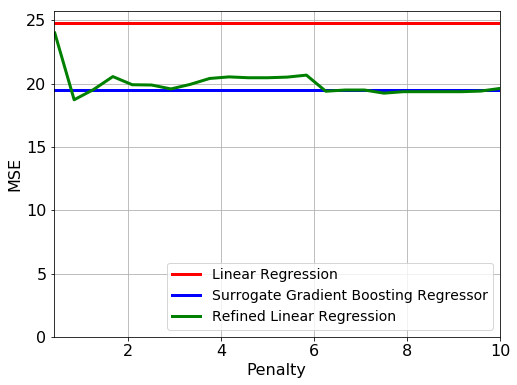

In [10]:
f = plt.figure(figsize=(8, 6))

standard_error = mean_squared_error(y_test, standard_predictions)
xgb_error = mean_squared_error(y_test, gb_predictions)

plt.rcParams.update({'font.size': 14})
plt.xlabel('Penalty', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.grid(True)
plt.axhline(standard_error, color='r', linewidth = 3,label='Linear Regression')
plt.axhline(xgb_error, color='b', linewidth = 3,label='Surrogate Gradient Boosting Regressor')
plt.plot(pens[1:], errors[1:], color = "g", linewidth = 3, label='Refined Linear Regression')

plt.ylim((0, max(max(errors[1:])+1, standard_error+1)))
plt.legend(loc = 'lower right')
plt.xlim([0.4, 10])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# f.set_size_inches(12,10, forward = True)

plt.show()


f.savefig("boston_results.pdf", bbox_inches='tight')

In [11]:
best_transformer.summary()

Numerical Variable CRIM
Selected intervals:
	[-Inf, 7.14)
	[7.14, 13.82)
	[13.82, 14.26)
	[14.26, 15.15)
	[15.15, 24.50)
	[24.50, 25.84)
	[25.84, 33.85)
	[33.85, 70.81)
	[70.81, 81.50)
	[81.50, Inf)
Numerical Variable ZN
Selected intervals:
	[-Inf, 30.53)
	[30.53, 33.53)
	[33.53, Inf)
Numerical Variable INDUS
Selected intervals:
	[-Inf, 1.55)
	[1.55, 3.19)
	[3.19, 4.28)
	[4.28, 10.29)
	[10.29, 26.68)
	[26.68, Inf)
Numerical Variable CHAS
Selected intervals:
	[-Inf, 0.50)
	[0.50, Inf)
Numerical Variable NOX
Selected intervals:
	[-Inf, 0.44)
	[0.44, 0.44)
	[0.44, 0.52)
	[0.52, 0.59)
	[0.59, 0.60)
	[0.60, 0.62)
	[0.62, 0.62)
	[0.62, 0.64)
	[0.64, 0.67)
	[0.67, 0.67)
	[0.67, 0.69)
	[0.69, 0.70)
	[0.70, 0.72)
	[0.72, 0.73)
	[0.73, Inf)
Numerical Variable RM
Selected intervals:
	[-Inf, 4.96)
	[4.96, 4.98)
	[4.98, 5.01)
	[5.01, 5.03)
	[5.03, 5.42)
	[5.42, 5.86)
	[5.86, 6.04)
	[6.04, 6.12)
	[6.12, 6.58)
	[6.58, 6.61)
	[6.61, 6.82)
	[6.82, 6.95)
	[6.95, 7.08)
	[7.08, 7.10)
	[7.10, 7.13)
	[7.13,

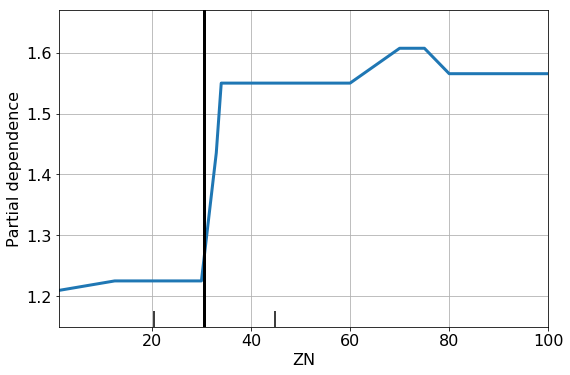

In [12]:
plt.rcParams["figure.figsize"] = [8, 8]

f, axis = plot_partial_dependence(surrogate_model, X, [1],
                                 line_kw = {"linewidth": 3})
plt.axvline(30.53, color = "black", linewidth=3.0)
plt.ylim(1.15, 1.67)
plt.xlim(1.2, 100)
plt.xlabel('ZN')
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Partial dependence", fontsize=16)
plt.xlabel("ZN", fontsize=16)

f.savefig("boston_PDP_ZN.pdf", bbox_inches='tight')

In [18]:
standard_predictions_error / surrogate_model_predictions_error

1.2685335901860655

In [20]:
standard_predictions_error / best_score

1.3224892333664882